# Museums in the Pandemic - Indicator matching validation 
**Authors**: Andrea Ballatore (KCL)

**Abstract**: Validation of matching process of indicators in text.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [277]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
from termcolor import colored
import sys
import spacy
import numpy as np
from numpy import arange
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
#import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number

print('env ok')

Conda env: mip_v1
/Users/andreaballatore/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks
env ok


## Connect to DB

It needs the DCS VPN active to work.

In [14]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

DB connected


## Setup spacy NLP

In [7]:
# install language model
!python -m spacy download en_core_web_sm
# Note: if this cell does not work, run the same command 
#       without "!" in the Anaconda terminal

     |████████████████████████████████| 12.0 MB 5.2 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=6e736cfbfe09463c336696b4717b7863a88b5d6766fe3bbf830fc9b77c861a42
  Stored in directory: /private/var/folders/84/_52b_kt95ybgx9pwl31_nvqh0000gn/T/pip-ephem-wheel-cache-dcoj7ilh/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
# set up the spacy environment
import spacy
from spacy import displacy
from collections import Counter
spacy.prefer_gpu()
# load language model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
# Spacy stopwords
#all_stopwords = nlp.Defaults.stop_words

In [8]:
# get text from websites

from analytics.an_websites import get_attribute_for_webpage_url

session_id = '20210420'
test_urls = ['https://www.britishmuseum.org/']
attrib_name = 'all_text' # 'title'

for url in test_urls:
    print(url)
    res = get_attribute_for_webpage_url(url, session_id, attrib_name, db_conn)
    if not res: continue
    print(res)
    blocks = res.split("\n")
    print("LEN", len(blocks))
    print(blocks)

https://www.britishmuseum.org/
Skip to main content Please enable JavaScript in your web browser to get the best experience. We use cookies to make our website work more efficiently, to provide you with more personalised services or advertising to you, and to analyse traffic on our website. For more information on how we use cookies and how to manage cookies, please follow the 'Read more' link, otherwise select 'Accept and close'. Read more about our cookie policy Accept and close the cookie policy Menu Main navigation Visit Toggle Visit submenu Back
to previous menu —
Visit —
Visit —
Family visits —
Group visits —
Audio guide —
Out-of-hours tours —
Tours and talks —
Object trails —
Accessibility —
Food and drink —
Late opening on Fridays —
Museum map Exhibitions and events Collection Toggle Collection submenu Back
to previous menu —
Collection —
Collection —
Collection online —
Galleries —
Blog —
Audio tour highlights —
The British Museum podcast Learn Toggle Learn submenu Back
to pre

## Annotations

These are manually created annotations (identified by the *example_id*) to identify indicators in the text.

In [3]:
# extract tokens from annotations
from analytics.text_models import get_indicator_annotations

indic_df, ann_df = get_indicator_annotations("../../")
ann_df

,text_phrases,indicator_code,indicator_attributes,notes,example_id
0,Closed now,closed_cur,NaN,NaN,0
1,closed to members of the public until further ...,closed_cur,NaN,NaN,1
2,closed until further notice,closed_cur,NaN,NaN,2
3,closed until Spring 2021,closed_cur,NaN,NaN,3
4,Closed: Until further notice,closed_cur,NaN,NaN,4
...,...,...,...,...,...
146,Bailiffgate is now closed due to Covid.,closed_cur,NaN,NaN,146
147,Visit our online shop,open_onlineshop,NaN,NaN,147
148,The new stunning Felton Group online exhibitio...,online_exhib,_description,NaN,148
149,Stay up to date with what's happening at Baili...,online_engag,NaN,NaN,149


In [10]:
# this is to debug the token extraction from the annotations.

ann_tokens_df = pd.DataFrame()

for index, row in ann_df.iterrows():
    txt = str(row['text_phrases']).strip()
    df = spacy_extract_tokens(txt)
    #print(df)
    df['example_id'] = row['example_id']
    df['indicator_code'] = row['indicator_code']
    ann_tokens_df = pd.concat([ann_tokens_df, df])

# output annotations tokens
fout = out_folder+'tmp/test_annotations_tokens.csv'
ann_tokens_df.to_csv(fout, index=False)
print(fout)

NameError: name 'ann_df' is not defined

## Indicator matching

This code identifies indicators in raw text

In [6]:
ftext = out_folder+'tmp/museum_text_tokens.csv'
text_df = pd.read_csv(ftext)
print(len(text_df))
text_df.sample(10)

findic = out_folder+'tmp/test_annotations_tokens.csv'
ann_df = pd.read_csv(findic)
print(len(ann_df))

ann_df

155
1857


,sentence_id,token,lemma,pos_tag,is_stop,example_id,indicator_code
0,1,Closed,close,VERB,False,0,closed_cur
1,1,now,now,ADV,True,0,closed_cur
2,1,closed,close,VERB,False,1,closed_cur
3,1,to,to,ADP,True,1,closed_cur
4,1,members,member,NOUN,False,1,closed_cur
...,...,...,...,...,...,...,...
1852,1,'ve,have,AUX,True,150,made_covid_safe
1853,1,made,make,VERB,True,150,made_covid_safe
1854,1,your,-PRON-,DET,True,150,made_covid_safe
1855,1,visit,visit,NOUN,False,150,made_covid_safe


Options for matches
- Case sensitive/insens (lower case) 
- match lemma
- match token
- stopwords or not

In [9]:
print(text_df.columns)
print(ann_df.columns)

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


In [42]:
# call test match 
muse_id = 'test.123'
df = match_musetext_indicators(muse_id, text_df, ann_df)

print(len(df))
fout = out_folder + 'tmp/all_matches_test.csv'
df.to_csv(fout, index=False)

1510


In [11]:
# a test query to the DB
assert db_conn

t = "analytics.text_indic_ann_matches"
sql = """select count(distinct muse_id) from {} t;""".format(t)
print(sql)
df = pd.read_sql(sql, db_conn)
df

NameError: name 'db_conn' is not defined

In [4]:
# get sample of matches museums
sample_df = mus_df.sample(10)
muse_ids = sample_df.muse_id.tolist()
muse_ids = str(muse_ids).replace('[','(').replace(']',')')
#print(muse_ids)
sql = """select * from {} t where muse_id in {};""".format(t, muse_ids)
print(sql)
df = pd.read_sql(sql, db_conn)

fn = out_folder + 'tmp/match_samples.tsv'
print(df.keep_stopwords.describe())
df.to_csv(fn, sep='\t', index=False)
df.describe().transpose()
df.columns

NameError: name 'mus_df' is not defined

In [13]:
# dump all matches from DB to a pickle file (SLOW)
sql = """select muse_id, example_id, sentence_id, indicator_code, token_n, lemma_n, 
                ann_overlap_lemma, ann_overlap_token, example_len, ann_ex_tokens, page_tokens,
                txt_overlap_lemma, txt_overlap_token, ann_overlap_criticwords
    from analytics.text_indic_ann_matches t where keep_stopwords;"""
df = pd.read_sql(sql, db_conn)
print("rows",len(df))

# write df to file
matches_fn = out_folder+'tmp/matches_dump_df.pik'
df.to_pickle(matches_fn)

NameError: name 'db_conn' is not defined

## Load matches from pik

`matches_dump_df_v1.pik` is used for Eval data v1, and v2 for Eval data v2 (with critical words).

In [19]:
# select which matches dataset to load

#matches_fn = out_folder+'tmp/matches_dump_df_v1.pik'
matches_fn = out_folder+'tmp/matches_dump_df_v2.pik'

df = pd.read_pickle(matches_fn)

# generate derived fields
df["lemmatoken_n"] = df[["lemma_n", "token_n"]].max(axis=1)
df["lemmatoken_n"].describe()

df["ann_overlap_tokenlemma"] = df["lemmatoken_n"]/df['example_len']

assert df.ann_overlap_tokenlemma.between(0,1).all(),'incorrect range'

df.sample(10)

,muse_id,example_id,sentence_id,indicator_code,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,ann_ex_tokens,page_tokens,txt_overlap_lemma,txt_overlap_token,ann_overlap_criticwords,lemmatoken_n,ann_overlap_tokenlemma
626144,mm.musa.216,ann_ex_00185,mus_page454804_sent00020,online_event,2.0,2.0,0.25000,0.25000,8,programme online talks which we will advertisi...,day visit bookings closure cancelled will refu...,0.16667,0.16667,0.0,2.0,0.250000
586611,mm.domus.SE483,ann_ex_00044,mus_page94090_sent00066,closed_perm,1.0,1.0,0.16667,0.16667,6,scheduled to re located near future,there will small charge head to take part,0.12500,0.12500,0.0,1.0,0.166667
644837,mm.domus.SW242,ann_ex_00180,mus_page447126_sent00094,online_event,1.0,1.0,0.14286,0.14286,7,tickets now sale our winter lecture series,most our places run gift aid entry scheme thei...,0.09091,0.09091,0.0,1.0,0.142857
728269,mm.mald.124,ann_ex_00032,mus_page57721_sent00009,closed_cur,0.0,1.0,0.25000,0.00000,4,closed following government guidelines,we encourage everybody to follow latest restri...,0.11111,0.00000,0.0,1.0,0.250000
706271,mm.ace.1248,ann_ex_00088,mus_page277835_sent00017,funding_fundraise,1.0,1.0,0.12500,0.12500,8,you able to support donation can so here,donation april commodore sx64,0.25000,0.25000,0.5,1.0,0.125000
546411,mm.domus.SE159,ann_ex_00085,mus_page826450_sent00020,funding_fundraise,0.0,1.0,0.11111,0.00000,9,you can make donation directly charity selecti...,making change victorian britain temporarily cl...,0.12500,0.00000,0.0,1.0,0.111111
581624,mm.domus.SE258,ann_ex_00156,mus_page669283_sent00058,lang_difficulty,1.0,1.0,0.20000,0.20000,5,these will undoubtedly difficult times,come go many times you like,0.16667,0.16667,0.5,1.0,0.200000
84408,mm.musa.345,ann_ex_00157,mus_page226877_sent00049,lang_difficulty,1.0,1.0,0.10000,0.10000,10,it unclear moment just how much will cover dif...,whole setting medieval banquet just perfect fo...,0.11111,0.11111,0.0,1.0,0.100000
133140,mm.domus.SE576,ann_ex_00267,mus_page640217_sent00010,staff_working,1.0,1.0,0.16667,0.16667,6,team continues to work winter months,trustees society members would like to apologi...,0.05882,0.05882,0.0,1.0,0.166667
212162,mm.domus.SE447,ann_ex_00155,mus_page386740_sent00008,lang_difficulty,1.0,1.0,0.25000,0.25000,4,serious financial impact museum,previous next find more discover more househol...,0.09091,0.09091,0.0,1.0,0.250000


## Descriptive stats

Describe the full matches dataset from the DB (800K entries for 400 museums).

### Match distributions

In [5]:
# descriptive stats of all values
#df.groupby('keep_stopwords').describe().transpose()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
token_n,883265.0,1.030551,0.497137,0.000000,1.00000,1.000000,1.00,8.0
lemma_n,883265.0,1.124612,0.441228,0.000000,1.00000,1.000000,1.00,8.0
ann_overlap_lemma,883265.0,0.203200,0.124995,0.000000,0.12500,0.166670,0.25,1.0
ann_overlap_token,883265.0,0.186740,0.131619,0.000000,0.11111,0.166670,0.25,1.0
example_len,883265.0,6.751379,3.198704,1.000000,4.00000,6.000000,8.00,17.0
lemmatoken_n,883265.0,1.146149,0.420205,1.000000,1.00000,1.000000,1.00,8.0
ann_overlap_tokenlemma,883265.0,0.209669,0.127575,0.058824,0.12500,0.166667,0.25,1.0


### Indicator stats

In [7]:
# describe indicators
indic_df = round(df['indicator_code'].value_counts(normalize=True)*100,1)
indic_df.columns = ['n_matches']
indic_df.to_csv(out_folder + 'tmp/indicator_stats.csv')
print('N matches =',len(df))
indic_df

N matches = 884399


funding_fundraise      19.0
reopen_intent          13.8
closed_cur             12.7
lang_difficulty        12.5
staff_working           6.2
open_onlineshop         4.8
funding_gov_emer        3.7
online_engag            3.7
staff_hiring            3.2
finance_health          2.7
funding_other_emer      2.6
reopen_plan             2.5
funding_did_not_get     2.3
closed_perm             2.1
online_event            1.8
open_cur                1.5
closed_indef            1.4
online_exhib            1.2
project_postpone        1.1
made_covid_safe         0.6
open_cafe               0.4
open_garden             0.3
staff_restruct          0.1
Name: indicator_code, dtype: float64

                 count      mean       std  min  25%  50%  75%  max
token_n       883265.0  1.030551  0.497137  0.0  1.0  1.0  1.0  8.0
lemma_n       883265.0  1.124612  0.441228  0.0  1.0  1.0  1.0  8.0
lemmatoken_n  883265.0  1.146149  0.420205  1.0  1.0  1.0  1.0  8.0


array([[<AxesSubplot:title={'center':'token_n'}>,
        <AxesSubplot:title={'center':'lemma_n'}>],
       [<AxesSubplot:title={'center':'lemmatoken_n'}>, <AxesSubplot:>]],
      dtype=object)

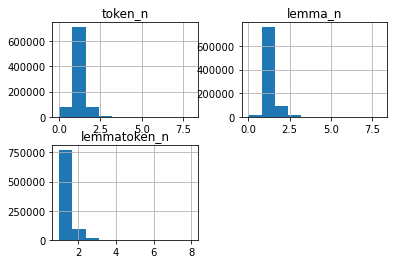

In [7]:
# distribution token_n and lemma_n
print(df[['token_n','lemma_n','lemmatoken_n']].describe().transpose())
df[['token_n','lemma_n','lemmatoken_n']].hist(bins=10)

array([[<AxesSubplot:title={'center':'lemmatoken_n'}>]], dtype=object)

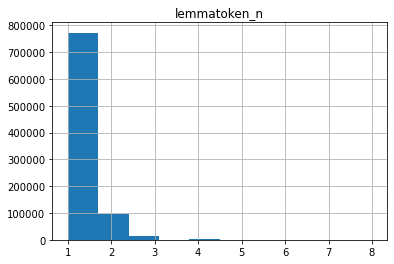

In [21]:
# histogram of number of matched lemma/token
df[['lemmatoken_n']].hist(bins=10)

             lemma_n
count  107526.000000
mean        2.167718
std         0.468068
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         8.000000


array([[<AxesSubplot:title={'center':'lemma_n'}>]], dtype=object)

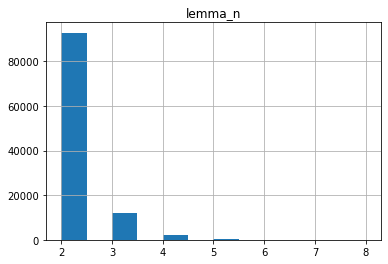

In [32]:
# exclude matches of a single lemma 
print(df[['lemma_n']][df.lemma_n > 1].describe())
df[['lemma_n']][df.lemma_n > 1].hist(bins=12)

### Overlaps distributions

                           count      mean       std       min      25%  \
ann_overlap_token       884399.0  0.187069  0.132090  0.000000  0.11111   
ann_overlap_lemma       884399.0  0.202859  0.125486  0.000000  0.12500   
ann_overlap_tokenlemma  884399.0  0.209418  0.128142  0.058824  0.12500   

                             50%   75%  max  
ann_overlap_token       0.166670  0.25  1.0  
ann_overlap_lemma       0.166670  0.25  1.0  
ann_overlap_tokenlemma  0.166667  0.25  1.0  


array([[<AxesSubplot:title={'center':'ann_overlap_tokenlemma'}>]],
      dtype=object)

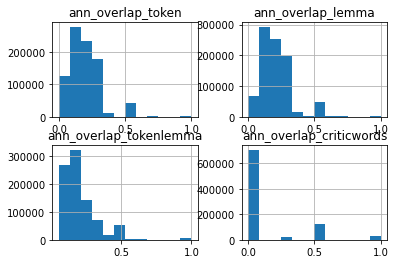

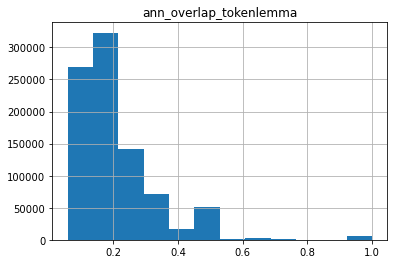

In [22]:
# compare the distributions of the overlap variables between annotations and web pages
print(df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma']].describe().transpose())
df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma','ann_overlap_criticwords']].hist(bins=12)

df[['ann_overlap_tokenlemma']].hist(bins=12)

count    884399.000000
mean          6.769431
std           3.191218
min           1.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          17.000000
Name: example_len, dtype: float64
matches with annotations > 1: 881913


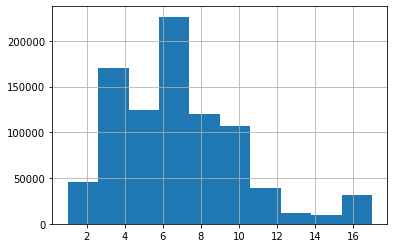

In [23]:
# show length of annotations
print(df['example_len'].describe())
df['example_len'].hist(bins=10)

# filter annotations that are too short: valid df
df = df[df['example_len']>1]
print('matches with annotations > 1:', len(df))

In [24]:
# count number of matches by indicator_code, to see which indicators are more or less popular
indic_df = df[['indicator_code','example_id']].groupby(['indicator_code']).describe()
indic_df = indic_df.sort_values(('example_id', 'unique'), ascending=False)
indic_df

example_id                            
                         count unique           top   freq
indicator_code                                            
funding_fundraise       168235     52  ann_ex_00101   6981
reopen_intent           120567     41  ann_ex_00251   5979
lang_difficulty         110359     38  ann_ex_00159   7626
closed_cur              110859     37  ann_ex_00029   7942
online_engag             32445     12  ann_ex_00172   6967
open_onlineshop          42028     11  ann_ex_00200   6593
staff_working            55064     11  ann_ex_00270   6886
funding_gov_emer         33123     11  ann_ex_00118   6022
staff_hiring             28282      8  ann_ex_00263   6396
online_event             15500      8  ann_ex_00185   3871
funding_did_not_get      20342      7  ann_ex_00054   6001
online_exhib             10211      7  ann_ex_00191   4406
finance_health           23678      6  ann_ex_00053   6519
closed_indef             12220      5  ann_ex_00041   3908
closed_perm              18703      5  ann_ex_00045   5792
funding_other_emer       23012      4  ann_ex_00127  10540
reopen_plan              21967      4  ann_ex_00256   6252
open_cur                 13590      3  ann_ex_00197   9380
project_postpone          9921      3  ann_ex_00210   6015
made_covid_safe           5184      1  ann_ex_00166   5184
open_cafe                 3577      1  ann_ex_00194   3577
open_garden               2561      1  ann_ex_00198   2561
staff_restruct             485      1  ann_ex_00266    485

## Evaluation of matching method

This is to make sure that matching mechanism identifies matches in museum websites accurately. It uses supervised machine learning.

## Evaluation of matching method

This dataset is manually annotated by the team. It contains 700 entries of matches that are annotated as valid/not valid.

Notes:
- Manually annotated by AB, AP, PW.
- Two independent annotators for each match.
- Disagreement on 11.5% of cases, manually resolved in discussion with a third independent annotator.
- in ann_ex_tokens, when the word "support" appears it implicitly intends to mean "financial support" whereas in the page_tokens "support" could be mean other types of support as well. Anyway, I marked these as "T" matches. 
- in ann_ex_tokens, phrases such as "currently closed" are implicitly intended to apply to the museum as a whole; whereas the page_tokens seem sometimes to be referreing to closures of parts of the museum, e.g. the grounds, the tea room etc.  I have generally marked these too as "T" matches. 

### Make sample of text matches

Choose sample for manual annotation of matches stratified on overlap bins, to make sure that there is an even distribution. The bins are selected manually based on the distribution, observing high values more in detail than low values (which are almost certainly invalid matches).

In [25]:
df['ann_overlap_tokenlemma']
cut_bins = [0, .25, .5, .6, .7, .8, .9, 1.01]
df['overlap_bin'] = pd.cut(df['ann_overlap_tokenlemma'], bins=cut_bins)
df['overlap_bin'].value_counts()

(0.0, 0.25]    721819
(0.25, 0.5]    151282
(0.6, 0.7]       3124
(0.9, 1.01]      2809
(0.5, 0.6]       1530
(0.7, 0.8]       1189
(0.8, 0.9]        160
Name: overlap_bin, dtype: int64

In [9]:
# Distribution of annotation lengths

# less than 0.2% of cases have annotation length == 1
#(len(df[df.example_len == 1])/len(df))*100

#df = df[df.example_len > 1]
df.example_len.describe()

count    884399.000000
mean          6.769431
std           3.191218
min           1.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          17.000000
Name: example_len, dtype: float64

In [26]:
# generate the stratified sample
sample_df = pd.DataFrame()
sample_n = 100
for bin_name, subdf in df.groupby('overlap_bin'):
    smpl = subdf.sample(sample_n, random_state=1359)
    sample_df = sample_df.append(smpl)
    
sample_df['overlap_bin'].value_counts()

sample_df['valid_match'] = ''

# shuffle sample
sample_df = sample_df.sample(frac=1.0)

# generate sample
sample_df.to_csv(out_folder+'tmp/match_sample_for_validation.tsv', index=False, sep='\t')
sample_df.to_excel(out_folder+'tmp/match_sample_for_validation.xlsx', index=False)

sample_df

,muse_id,example_id,sentence_id,indicator_code,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,ann_ex_tokens,page_tokens,txt_overlap_lemma,txt_overlap_token,ann_overlap_criticwords,lemmatoken_n,ann_overlap_tokenlemma,overlap_bin,valid_match
455588,mm.ace.1261,ann_ex_00034,mus_page665509_sent00019,closed_cur,5.0,5.0,0.83333,0.83333,6,line national restrictions museum temporarily ...,seacity museum temporarily closed current nati...,0.17241,0.17241,1.0,5.0,0.833333,"(0.8, 0.9]",
751792,mm.aim.0599,ann_ex_00233,mus_page522556_sent00065,reopen_intent,1.0,1.0,0.25000,0.25000,4,welcoming you back soon,otherwise we ’ll assume you ok to continue,0.12500,0.12500,0.0,1.0,0.250000,"(0.0, 0.25]",
538930,mm.domus.SE158,ann_ex_00027,mus_page782547_sent00002,closed_cur,2.0,2.0,1.00000,1.00000,2,we closed,light recent government announcements regardin...,0.10000,0.10000,1.0,2.0,1.000000,"(0.9, 1.01]",
874678,mm.aim.0112,ann_ex_00018,mus_page599129_sent00013,closed_cur,1.0,1.0,0.33333,0.33333,3,we currently closed,sadly current guidelines reopening safety our ...,0.04348,0.04348,0.0,1.0,0.333333,"(0.25, 0.5]",
619505,mm.domus.SE434,ann_ex_00000,mus_page247895_sent00029,closed_cur,1.0,1.0,0.50000,0.50000,2,closed now,some negotiating proposal accepted peninsula b...,0.07143,0.07143,0.0,1.0,0.500000,"(0.25, 0.5]",
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127322,mm.domus.SE505,ann_ex_00265,mus_page730409_sent00037,staff_hiring,3.0,3.0,0.75000,0.75000,4,we always looking volunteers,farmland museum denny abbey relies small staff...,0.15000,0.15000,1.0,3.0,0.750000,"(0.7, 0.8]",
456310,mm.ace.1261,ann_ex_00277,mus_page665509_sent00023,staff_working,3.0,3.0,0.75000,0.75000,4,we continuing to work,we also want to thank our fantastic staff volu...,0.15000,0.15000,0.5,3.0,0.750000,"(0.7, 0.8]",
154668,mm.wiki.352,ann_ex_00226,mus_page837442_sent00005,reopen_intent,3.0,3.0,0.60000,0.60000,5,we hope to announce bring,we hope brief description images will tempt yo...,0.18750,0.18750,0.0,3.0,0.600000,"(0.5, 0.6]",
272689,mm.domus.NE029,ann_ex_00097,mus_page898827_sent00015,funding_fundraise,3.0,3.0,0.60000,0.60000,5,please support us time donation,our continued closure will an even greater imp...,0.23077,0.23077,0.5,3.0,0.600000,"(0.5, 0.6]",


#### Eval data v1

This version has no _critical word_ matches and is based on the match sample v5. Stored in _matches_valid_ann_df_v1.pik_.

In [23]:
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v5.xlsx')
print(len(valid_ann_df))
print(valid_ann_df.columns)

# generate dummy vars
indicator_dummy_df = pd.get_dummies(valid_ann_df[['indicator_code']], drop_first=True)
indicator_dummy_vars = indicator_dummy_df.columns
print(valid_ann_df.shape)
valid_ann_df = pd.concat([valid_ann_df, indicator_dummy_df], axis=1)
print(valid_ann_df.shape)
print(indicator_dummy_vars)
valid_ann_df['valid_match_b'] = valid_ann_df['valid_match'].map({'T': True, 'F': False})
valid_ann_df['valid_match_b2'] = valid_ann_df['valid_match_2'].map({'T': True, 'F': False})
valid_ann_df.sample(10)

# add extra vars from matches
idx_cols = ['muse_id', 'example_id', 'sentence_id', 'indicator_code']
cols = idx_cols + ['txt_overlap_lemma','txt_overlap_token']
n = len(valid_ann_df)
valid_ann_df = valid_ann_df.merge(df[cols], on=idx_cols)
assert len(valid_ann_df) == n,len(valid_ann_df)

# derived fields
valid_ann_df["txt_overlap_tokenlemma"] = valid_ann_df[["txt_overlap_lemma", "txt_overlap_token"]].max(axis=1)

assert valid_ann_df.txt_overlap_tokenlemma.between(0,1).all(),'incorrect range'

valid_ann_df.to_pickle(out_folder+'tmp/matches_valid_ann_df_v1.pik')

700
Index(['muse_id', 'example_id', 'sentence_id', 'indicator_code', 'token_n',
       'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'ann_ex_tokens', 'page_tokens', 'lemmatoken_n',
       'ann_overlap_tokenlemma', 'overlap_bin', 'valid_match', 'annotator',
       'valid_match_2', 'Unnamed: 17'],
      dtype='object')
(700, 18)
(700, 37)
Index(['indicator_code_closed_indef', 'indicator_code_closed_perm',
       'indicator_code_finance_health', 'indicator_code_funding_did_not_get',
       'indicator_code_funding_fundraise', 'indicator_code_funding_gov_emer',
       'indicator_code_funding_other_emer', 'indicator_code_lang_difficulty',
       'indicator_code_online_engag', 'indicator_code_online_event',
       'indicator_code_online_exhib', 'indicator_code_open_cafe',
       'indicator_code_open_cur', 'indicator_code_open_onlineshop',
       'indicator_code_project_postpone', 'indicator_code_reopen_intent',
       'indicator_code_reopen_plan', 'indicator_code_

AssertionError: 423

#### Eval data v2

This version includes the overlap with critical words (`ann_overlap_criticwords`). It is based on the match sample v5, joined with the full match information.

In [36]:
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v5.xlsx')
orig_valid_ann_df = valid_ann_df
print(len(valid_ann_df))
print(valid_ann_df.columns)
print(len(df))

valid_matches = valid_ann_df[['muse_id','sentence_id','page_tokens','indicator_code',
                              'ann_ex_tokens','valid_match']].drop_duplicates()

all_matches = df

# Note: because IDs example_id mismatch, match rows based on tokens
assert len(all_matches)==881913,len(all_matches)
print(df.columns)

df2 = valid_matches.merge(all_matches, how='left',
            on=['muse_id','sentence_id','ann_ex_tokens','indicator_code','page_tokens']) 

#all_matches
valid_ann_df = df2.drop('example_id',axis=1).drop_duplicates()
valid_ann_df["txt_overlap_tokenlemma"] = valid_ann_df[["txt_overlap_lemma", "txt_overlap_token"]].max(axis=1)
n = 700

valid_ann_df = valid_ann_df.sample(n)
valid_ann_df = valid_ann_df[~valid_ann_df.lemma_n.isna()]

valid_ann_df['valid_match_b'] = valid_ann_df['valid_match'].map({'T': True, 'F': False})

# count invalid matches
#print(valid_ann_df[['ann_ex_tokens','valid_match_b']].value_counts().count())
#print(valid_ann_df[['ann_ex_tokens','valid_match_b']].pivot(index="ann_ex_tokens", columns="valid_match_b"))

indicator_dummy_df = pd.get_dummies(valid_ann_df[['indicator_code']], drop_first=True)
indicator_dummy_vars = indicator_dummy_df.columns
valid_ann_df = pd.concat([valid_ann_df, indicator_dummy_df], axis=1)

#del all_matches, valid_matches
print(len(valid_ann_df))
print(valid_ann_df.columns)
valid_ann_df.to_excel(out_folder+'tmp/match_sample_for_validation-v6.xlsx', index=False)

del df2

700
Index(['muse_id', 'example_id', 'sentence_id', 'indicator_code', 'token_n',
       'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'ann_ex_tokens', 'page_tokens', 'lemmatoken_n',
       'ann_overlap_tokenlemma', 'overlap_bin', 'valid_match', 'annotator',
       'valid_match_2', 'Unnamed: 17'],
      dtype='object')
881913
Index(['muse_id', 'example_id', 'sentence_id', 'indicator_code', 'token_n',
       'lemma_n', 'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'ann_ex_tokens', 'page_tokens', 'txt_overlap_lemma',
       'txt_overlap_token', 'ann_overlap_criticwords', 'lemmatoken_n',
       'ann_overlap_tokenlemma', 'overlap_bin'],
      dtype='object')
691
Index(['muse_id', 'sentence_id', 'page_tokens', 'indicator_code',
       'ann_ex_tokens', 'valid_match', 'token_n', 'lemma_n',
       'ann_overlap_lemma', 'ann_overlap_token', 'example_len',
       'txt_overlap_lemma', 'txt_overlap_token', 'ann_overlap_criticwords',
       'lemmatoken_n'

In [56]:
# convert validation annotations to pikle
valid_ann_df = pd.read_excel(out_folder+'data/annotations/match_sample_for_validation-v6.xlsx')
print(len(valid_ann_df))
valid_ann_df.to_pickle(out_folder+'tmp/matches_valid_ann_df_v2.pik')
valid_ann_df.sample(5)

700


,muse_id,sentence_id,page_tokens,indicator_code,ann_ex_tokens,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,...,indicator_code_online_event,indicator_code_online_exhib,indicator_code_open_cafe,indicator_code_open_cur,indicator_code_open_onlineshop,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_working
542,mm.domus.NW070,mus_page15046_sent00016,we look forward welcoming you back soon,reopen_intent,we look forward welcoming back soon able safe,6,6,0.75000,0.75000,8,...,0,0,0,0,0,0,1,0,0,0
143,mm.misc.221,mus_page233401_sent00020,how to book tickets you member your ticket wil...,closed_cur,to temporarily close,1,1,0.33333,0.33333,3,...,0,0,0,0,0,0,0,0,0,0
420,mm.ace.1166,mus_page501859_sent00034,update latest england lockdown circumstances w...,closed_cur,to close doors,1,2,0.66667,0.33333,3,...,0,0,0,0,0,0,0,0,0,0
625,mm.domus.WM058,mus_page43185_sent00106,we will announce our reopening date following ...,reopen_intent,we can reopen,1,2,0.66667,0.33333,3,...,0,0,0,0,0,0,1,0,0,0
690,mm.domus.SE085,mus_page325189_sent00017,you would like to support us we opened an onli...,open_onlineshop,online shop,2,2,1.00000,1.00000,2,...,0,0,0,0,1,0,0,0,0,0


### Simple threshold method

This is a matching method that uses only a threshold of `ann_overlap_tokenlemma` to select valid matches. It gives ok results, but not comparable to the other methods. Best result: accuracy .84, false positives 13%.

In [39]:
# observe distribution of value
len(valid_ann_df)
print(valid_ann_df.ann_overlap_tokenlemma.describe())

count    700.000000
mean       0.636530
std        0.264195
min        0.058824
25%        0.500000
50%        0.666667
75%        0.833333
max        1.000000
Name: ann_overlap_tokenlemma, dtype: float64


In [18]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# test precision_recall_fscore_support function
precision_recall_fscore_support([True, False, True, False], [True, False, True, True], average='binary')

(0.6666666666666666, 1.0, 0.8, None)

In [43]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

thdf = valid_ann_df.copy()

resdf = pd.DataFrame()

# loop through thresholds
for th in arange(.2,1.001,.05):
    print("---\nKeeping values ann_overlap_tokenlemma above: ",th)
    # PICK A VARIABLE
    thdf['predicted'] = thdf.ann_overlap_tokenlemma >= th
    #thdf['predicted'] = thdf.ann_overlap_criticwords >= th
    
    precision, recall, fscore, support = precision_recall_fscore_support(thdf.valid_match_b, thdf.predicted, average='binary')
    print(thdf.predicted.value_counts())
    stats = classification_report(thdf.valid_match_b, thdf.predicted)

    # confusion matrix
    confmat = confusion_matrix(thdf.valid_match_b, thdf.predicted, normalize='all')
    tn, fp, fn, tp = confmat.ravel()
    print('false positives %:',round(fp*100,1))

    subdf = pd.DataFrame.from_dict({'threshold':[th], 'precision':[round(precision,3)], 'recall':[round(recall,3)], 
            'fscore':[round(fscore,3)], 
            'accuracy': round(accuracy_score(thdf.valid_match_b, thdf.predicted),3),
            'false_positives': round(fp,3)})
    del tn, fp, fn, tp
    resdf = pd.concat([resdf, subdf])

resdf = resdf.reset_index()
resdf

---
Keeping values ann_overlap_tokenlemma above:  0.2
True     636
False     64
Name: predicted, dtype: int64
false positives %: 28.6
---
Keeping values ann_overlap_tokenlemma above:  0.25
True     622
False     78
Name: predicted, dtype: int64
false positives %: 26.6
---
Keeping values ann_overlap_tokenlemma above:  0.3
True     596
False    104
Name: predicted, dtype: int64
false positives %: 23.6
---
Keeping values ann_overlap_tokenlemma above:  0.35
True     548
False    152
Name: predicted, dtype: int64
false positives %: 17.1
---
Keeping values ann_overlap_tokenlemma above:  0.39999999999999997
True     547
False    153
Name: predicted, dtype: int64
false positives %: 17.0
---
Keeping values ann_overlap_tokenlemma above:  0.44999999999999996
True     539
False    161
Name: predicted, dtype: int64
false positives %: 16.3
---
Keeping values ann_overlap_tokenlemma above:  0.49999999999999994
True     539
False    161
Name: predicted, dtype: int64
false positives %: 16.3
---
Keeping 

,index,threshold,precision,recall,fscore,accuracy,false_positives
0,0,0.20,0.686,1.000,0.813,0.714,0.286
1,0,0.25,0.701,1.000,0.824,0.734,0.266
2,0,0.30,0.723,0.989,0.835,0.757,0.236
3,0,0.35,0.781,0.982,0.870,0.817,0.171
4,0,0.40,0.782,0.982,0.871,0.819,0.170
5,0,0.45,0.788,0.975,0.872,0.821,0.163
6,0,0.50,0.788,0.975,0.872,0.821,0.163
7,0,0.55,0.822,0.940,0.877,0.836,0.127
8,0,0.60,0.826,0.938,0.879,0.839,0.123
9,0,0.65,0.841,0.778,0.808,0.770,0.091


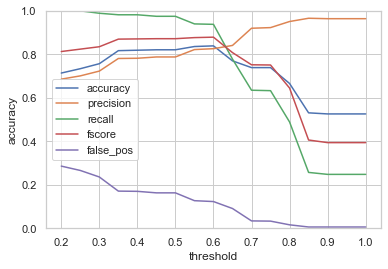

In [46]:
import seaborn as sns
p = sns.lineplot(data=resdf, x="threshold", y="accuracy", label='accuracy')
p = sns.lineplot(data=resdf, x="threshold", y="precision", label='precision')
p = sns.lineplot(data=resdf, x="threshold", y="recall", label='recall')
p = sns.lineplot(data=resdf, x="threshold", y="fscore", label='fscore')
p = sns.lineplot(data=resdf, x="threshold", y="false_positives", label='false_pos')
p.set(ylim=(0,1))
p.legend()

Show mean values by indicator code.

In [45]:
valid_ann_df.groupby('indicator_code').mean()

,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,txt_overlap_lemma,txt_overlap_token,ann_overlap_criticwords,lemmatoken_n,ann_overlap_tokenlemma,...,indicator_code_online_event,indicator_code_online_exhib,indicator_code_open_cafe,indicator_code_open_cur,indicator_code_open_onlineshop,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_working
indicator_code,,,,,,,,,,,,,,,,,,,,,
closed_cur,2.104972,1.950276,0.602482,0.676844,3.325967,0.217542,0.252979,0.553407,2.226519,0.713768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
closed_indef,2.473684,2.368421,0.712281,0.735965,3.368421,0.244473,0.246768,0.640351,2.526316,0.753509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
closed_perm,1.333333,2.000000,0.326923,0.217950,10.000000,0.249640,0.108227,0.166667,2.000000,0.326923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
finance_health,2.000000,2.000000,0.400000,0.400000,5.000000,0.234845,0.234845,0.250000,2.000000,0.400000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
funding_did_not_get,1.000000,1.250000,0.218750,0.156250,7.000000,0.080305,0.070690,0.208333,1.250000,0.218750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
funding_fundraise,1.857143,2.120879,0.573287,0.492060,4.648352,0.192470,0.168185,0.459707,2.120879,0.573287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
funding_gov_emer,1.333333,1.333333,0.127273,0.127273,10.333333,0.122863,0.122863,0.000000,1.333333,0.127273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
funding_other_emer,1.333333,1.333333,0.095173,0.095173,14.000000,0.132212,0.132212,0.083333,1.333333,0.095173,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lang_difficulty,1.581395,1.790698,0.387403,0.321290,5.255814,0.122857,0.104179,0.186047,1.813953,0.392055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Show mean values by valid/not valid matches.

In [47]:
valid_ann_df.groupby('valid_match_b').mean()

,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,txt_overlap_lemma,txt_overlap_token,ann_overlap_criticwords,lemmatoken_n,ann_overlap_tokenlemma,...,indicator_code_online_event,indicator_code_online_exhib,indicator_code_open_cafe,indicator_code_open_cur,indicator_code_open_onlineshop,indicator_code_project_postpone,indicator_code_reopen_intent,indicator_code_reopen_plan,indicator_code_staff_hiring,indicator_code_staff_working
valid_match_b,,,,,,,,,,,,,,,,,,,,,
False,1.545455,1.700758,0.397310,0.358220,5.234848,0.140143,0.129757,0.207702,1.727273,0.407132,...,0.026515,0.011364,0.026515,0.011364,0.049242,0.011364,0.166667,0.056818,0.018939,0.037879
True,3.043578,3.123853,0.732159,0.724057,4.279817,0.334356,0.332226,0.731651,3.233945,0.775431,...,0.011468,0.016055,0.000000,0.020642,0.027523,0.000000,0.380734,0.022936,0.006881,0.038991


### Run traditional models

Compare traditional classifiers, e.g. SVM, Logistic Regression, and generate the evaluation results in a data frame. Compare binary classifier to determine whether a match between an annotation and a sentence in a museum website is valid or not.

- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://www.analyticsvidhya.com/blog/2021/04/beginners-guide-to-logistic-regression-using-python/

In [58]:
# load ML packages
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [131]:
def run_traditional_model(num_df, valid_ann_df_fn, var_group, test_size, clf):
    print('run_traditional_model', i, valid_ann_df_fn, len(var_group), test_size, clf)
    # prep data
    y_data = num_df['valid_match_b']
    x_data = num_df.drop('valid_match_b', axis = 1)
    x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = test_size, random_state=2)

    # Train the model and create predictions
    clf.fit(x_training_data, y_training_data)
    predictions = clf.predict(x_test_data)

    # confusion matrix
    confmat = confusion_matrix(y_test_data, predictions, normalize='all')
    tn, fp, fn, tp = confmat.ravel()

    # evaluation metrics
    precision, recall, fscore, support = precision_recall_fscore_support(y_test_data, predictions, average='binary')
    acc = accuracy_score(y_test_data, predictions)
    del x_training_data, x_test_data, y_training_data, y_test_data

    # cross-validation
    crossval_predicted = cross_val_predict(clf, x_data, y_data, cv=6)
    crossval_acc = round(accuracy_score(y_data, crossval_predicted),2)
    del crossval_predicted

    # pack results
    subdf = pd.DataFrame.from_dict({
        'trial_i': i,
        'eval_file': valid_ann_df_fn,
        'var_group':' '.join(var_group),
        'model':str(clf), 'test_size':test_size, 'x_shape':str(x_data.shape),
        'accuracy': round(acc,2),
        'precision':[round(precision,3)], 'recall':[round(recall,3)], 
        'fscore':[round(fscore,3)], 
        'crossval_acc': crossval_acc,
        'false_pos': round(fp,2),'false_neg': round(fn,2)})
    return subdf

# prep variables
eval_dfs = [ 'matches_valid_ann_df_v2.pik']

in_var_groups = [
    #['txt_overlap_tokenlemma'],
    #['ann_overlap_tokenlemma'],
    #['ann_overlap_criticwords'],
    #['txt_overlap_token','txt_overlap_lemma','ann_overlap_criticwords'],
    #['txt_overlap_token','ann_overlap_criticwords','example_len'],
    ['lemmatoken_n','txt_overlap_token','ann_overlap_criticwords','example_len'],
    ['lemmatoken_n','ann_overlap_tokenlemma','txt_overlap_lemma','example_len'],
]

var_groups = []
for x in in_var_groups: 
    x1 = x.copy()
    x1.extend(indicator_dummy_vars.tolist()) 
    x.append('valid_match_b')
    x1.append('valid_match_b')
    var_groups.append(x)
    var_groups.append(x1)
    
# iterate over models
models = [
    #LogisticRegression(random_state=0),
    #svm.SVC(random_state=0),
    #MLPClassifier(random_state=1),
    #GaussianNB(),
    #KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5)
]

for i in [5,10,20]:
    models.append(RandomForestClassifier(max_depth=i)) # random_state=10

split_sizes = [.3,.4,.5]
repeat_trials = 10

resdf = pd.DataFrame()
assert len(models) > 0

# generate all results (SLOW)
for valid_ann_df_fn in eval_dfs:
    # load validation dataset
    print(40*'-')
    print(valid_ann_df_fn)
    valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)
    
    for var_group in var_groups:
        # extract numeric matrix
        #if not pd.Series(var_group).isin(valid_ann_df.columns).all():
        # skip
        #    continue
        print(valid_ann_df.columns)
        print(var_group)
        num_df = valid_ann_df[var_group]
        # loop through test sizes
        for test_size in split_sizes:
            # loop through models
            for clf in models:
                # repeat trial N times
                for i in range(repeat_trials):
                    subdf = run_traditional_model(num_df, valid_ann_df_fn, var_group, test_size, clf)
                    subdf['trial_i'] = i
                    resdf = pd.concat([resdf, subdf])
        del num_df
    del valid_ann_df

resdf = resdf.sort_values(by='accuracy', ascending=False)
resdf.to_excel(out_folder+'tmp/match_validation_comparison_traditional_models.xlsx', index=False)
resdf

----------------------------------------
matches_valid_ann_df_v2.pik
Index(['muse_id', 'sentence_id', 'page_tokens', 'indicator_code',
       'ann_ex_tokens', 'token_n', 'lemma_n', 'ann_overlap_lemma',
       'ann_overlap_token', 'example_len', 'txt_overlap_lemma',
       'txt_overlap_token', 'ann_overlap_criticwords', 'lemmatoken_n',
       'ann_overlap_tokenlemma', 'txt_overlap_tokenlemma', 'valid_match_b',
       'indicator_code_closed_indef', 'indicator_code_closed_perm',
       'indicator_code_finance_health', 'indicator_code_funding_did_not_get',
       'indicator_code_funding_fundraise', 'indicator_code_funding_gov_emer',
       'indicator_code_funding_other_emer', 'indicator_code_lang_difficulty',
       'indicator_code_online_engag', 'indicator_code_online_event',
       'indicator_code_online_exhib', 'indicator_code_open_cafe',
       'indicator_code_open_cur', 'indicator_code_open_onlineshop',
       'indicator_code_project_postpone', 'indicator_code_reopen_intent',
       '

,trial_i,eval_file,var_group,model,test_size,x_shape,accuracy,precision,recall,fscore,crossval_acc,false_pos,false_neg
0,8,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=10),0.4,"(700, 23)",0.89,0.928,0.898,0.913,0.86,0.05,0.07
0,5,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=20),0.4,"(700, 4)",0.89,0.948,0.887,0.917,0.84,0.03,0.08
0,1,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=10),0.4,"(700, 4)",0.89,0.938,0.887,0.912,0.84,0.04,0.08
0,1,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=10),0.4,"(700, 23)",0.89,0.928,0.898,0.913,0.87,0.05,0.07
0,8,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=5),0.3,"(700, 23)",0.89,0.895,0.934,0.914,0.87,0.07,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,9,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=20),0.5,"(700, 4)",0.79,0.840,0.843,0.842,0.78,0.11,0.10
0,3,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=20),0.5,"(700, 4)",0.78,0.822,0.843,0.833,0.77,0.12,0.10
0,4,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=20),0.5,"(700, 4)",0.78,0.828,0.835,0.831,0.78,0.11,0.11
0,5,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=20),0.5,"(700, 4)",0.78,0.829,0.843,0.836,0.78,0.11,0.10


### Feature selection

Quantify contribution of each variable in the matching process using recursive feature elimination (RFE).

In [62]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

def backward_elimination():
    """ TODO """
    cols = list(X.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols
    print(selected_features_BE)
    return selected_features_BE

eval_dfs = ['matches_valid_ann_df_v2.pik']

for valid_ann_df_fn in eval_dfs:
    # load validation dataset
    print(40*'-')
    print(valid_ann_df_fn)
    valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)
    x_data = valid_ann_df.select_dtypes(include=[np.number])
    x_data = x_data.drop(['ann_overlap_tokenlemma','txt_overlap_tokenlemma'], axis = 1)
    print(len(valid_ann_df))
    y_data = valid_ann_df['valid_match_b']

    if False:
        # create pipeline with stratified K fold
        model = RandomForestClassifier(max_depth=5, random_state=10)
        model_est = RandomForestClassifier(max_depth=5, random_state=10)
        rfe = RFE(estimator=model_est, n_features_to_select=5)
        pipeline = Pipeline(steps=[('s',rfe),('m',model)])
        # evaluate model
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=10)
        n_scores = cross_val_score(pipeline, x_data, y_data, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        # report performance
        print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    if True:
        estimator = RandomForestClassifier(max_depth=5, random_state=10)
        # Recursive Feature Elimination (RFE)
        selector = RFE(estimator, n_features_to_select=5, step=1)
        selector = selector.fit(x_data, y_data)
        print(selector.support_)
        print(selector.ranking_)
        from operator import itemgetter
        features = x_data.columns.to_list()
        for x, y in (sorted(zip(selector.ranking_ , features), key=itemgetter(0))):
            print(x, y)

----------------------------------------
matches_valid_ann_df_v2.pik
700
[False False  True  True False False  True  True  True False False False
 False False False False False False False False False False False False
 False False False False]
[ 3  4  1  1  5  2  1  1  1 13 14 17 21 10 24 22  6 23 18 20  9  8 15 19
  7 12 16 11]
1 ann_overlap_lemma
1 ann_overlap_token
1 txt_overlap_token
1 ann_overlap_criticwords
1 lemmatoken_n
2 txt_overlap_lemma
3 token_n
4 lemma_n
5 example_len
6 indicator_code_lang_difficulty
7 indicator_code_reopen_intent
8 indicator_code_open_cur
9 indicator_code_open_cafe
10 indicator_code_funding_fundraise
11 indicator_code_staff_working
12 indicator_code_reopen_plan
13 indicator_code_closed_indef
14 indicator_code_closed_perm
15 indicator_code_open_onlineshop
16 indicator_code_staff_hiring
17 indicator_code_finance_health
18 indicator_code_online_event
19 indicator_code_project_postpone
20 indicator_code_online_exhib
21 indicator_code_funding_did_not_get
22 i

### Deep Learning

Find valid matches using deep learning and `keras`.

- https://machinelearningmastery.com/tutorial-first-neural-network-python-keras
- https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/


In [256]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.metrics import FalsePositives, BinaryAccuracy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from numpy import mean
from numpy import std

# https://stackoverflow.com/questions/48285129/saving-best-model-in-keras/48286003
early_stopping_monitor = EarlyStopping(
    monitor='binary_accuracy',
    min_delta=0,
    patience=150,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

def build_convolutional_nn(input_dim, neurons):
    print('build_convolutional_nn: ', input_dim, neurons)
    model = Sequential()
    # add first layer
    model.add(Dense(neurons[0], input_dim=input_dim, activation='relu'))
    # add intermediate layers
    for neur in neurons[1:]:
        model.add(Dense(neur, activation='relu'))
    # add final layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[BinaryAccuracy()])
    return model


def run_deep_learning(df, test_size, neurons, batch_size, early_stopping_monitor=early_stopping_monitor):
    """ create and call a Keras model with layers """
    print('run_deep_learning', df.shape, test_size, neurons, batch_size)
    # get only numeric columns
    x_data = df.select_dtypes(include=[np.number])
    if True:
        # create scaler
        scaler = MinMaxScaler()
        # fit and transform in one step
        cols = x_data.columns
        x_data = pd.DataFrame(scaler.fit_transform(x_data),columns=cols)
    
    y_data = df[['valid_match_b']]
    # train/test split
    x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x_data, y_data, test_size = test_size)
    #print('train/test',x_training_data.shape, x_test_data.shape, y_training_data.shape, y_test_data.shape)

    # define the keras model
    model = build_convolutional_nn(len(x_data.columns), neurons)
    
    if True:
        # fit model
        # https://keras.io/guides/training_with_built_in_methods/
        history = model.fit(x_training_data, y_training_data, epochs=150, batch_size=batch_size, verbose=0,
                           callbacks=[early_stopping_monitor]) # , validation_split=test_size
        # plot metrics
        #pyplot.plot(history.history['binary_accuracy'])
        #pyplot.show()
        # evaluate model
        loss, accuracy = model.evaluate(x_test_data, y_test_data, verbose=0)
        print("-> acc ",accuracy)
        # get predicted values
        pred_y = (model.predict(x_test_data) > 0.5).astype("bool")
        # unpack results
        pred_y = [item for sublist in pred_y for item in sublist]
        # calculate IR metrics
        precision, recall, fscore, support = precision_recall_fscore_support(y_test_data, pred_y, average='binary')        
        # calculate confusion matrix
        confmat = confusion_matrix(y_test_data, pred_y, normalize='all')
        tn, fp, fn, tp = confmat.ravel()
        del pred_y
        # save results
        res_d = {
            'neurons': [str(neurons)],
            'batch_size': [batch_size],
            'test_size_split': [test_size],
            'x_shape': [str(x_data.shape)],
            'accuracy': [round(accuracy,3)],
            'precision': [round(precision,3)],
            'recall': [round(recall,3)],
            'fscore': [round(fscore,3)],
            'false_pos': [round(fp,3)],
            'false_neg': [round(fn,3)],
            'loss': [round(loss,3)],
            'accuracy_train_max': [round(max(history.history['binary_accuracy']),3)]
        }
        del tn, fp, fn, tp
        return res_d, model

    if False:
        # cross validation
        #estimator = KerasClassifier(build_fn=model, epochs=100, batch_size=5, verbose=0)
        #kfold = StratifiedKFold(n_splits=10, shuffle=True)
        #results = cross_val_score(estimator, x_data, y_data, cv=kfold)
        #print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
        estimators = []
        estimators.append(('standardize', StandardScaler()))
        estimators.append(('mlp', KerasClassifier(build_fn=model, epochs=100, batch_size=5, verbose=0)))
        pipeline = Pipeline(estimators)
        kfold = StratifiedKFold(n_splits=10, shuffle=True)
        results = cross_val_score(pipeline, x_data, y_data, cv=kfold)
        print("Smaller: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [258]:
# set input for deep learning        
valid_ann_df_fn = 'matches_valid_ann_df_v2.pik'
valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)

neuron_blocks = [
    [8],
    [8,16],
    #[32,32],
    #[8,16,32],
    #[256,512],
    #[32,64,512]
]
n_trials = 10
test_split_sizes = [.4] # [.4]
batch_sizes = [8] #[1,8,32]

# loop over parameters
resdf = pd.DataFrame()

for batch_size in batch_sizes:
    for test_size in test_split_sizes:
        for neur in neuron_blocks:
            print("-"*40)
            for i in range(n_trials):
                res_d, _ = run_deep_learning(valid_ann_df, test_size, neur, batch_size)
                df = pd.DataFrame.from_dict(res_d)
                df['trial'] = i
                resdf = pd.concat([resdf, df])
                del df
            
resdf = resdf.reset_index()
resdf.to_excel(out_folder+'tmp/match_validation_model_comparison_deeplearning.xlsx', index=False)

del valid_ann_df, test_split_sizes, neuron_blocks, n_trials, valid_ann_df_fn

resdf

----------------------------------------
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8714285492897034
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8678571581840515
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8928571343421936
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8999999761581421
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8857142925262451
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8714285492897034
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8785714507102966
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8785714507102966
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.8999999761581421
run_deep_learning (700, 36) 0.4 [8] 8
build_convolutional_nn:  30 [8]
-> acc  0.871428

,index,neurons,batch_size,test_size_split,x_shape,accuracy,precision,recall,fscore,false_pos,false_neg,loss,accuracy_train_max,trial
0,0,[8],8,0.4,"(700, 30)",0.871,0.871,0.923,0.896,0.082,0.046,0.296,0.914,0
1,0,[8],8,0.4,"(700, 30)",0.868,0.866,0.939,0.901,0.093,0.039,0.329,0.919,1
2,0,[8],8,0.4,"(700, 30)",0.893,0.898,0.938,0.918,0.068,0.039,0.281,0.914,2
3,0,[8],8,0.4,"(700, 30)",0.900,0.910,0.940,0.924,0.061,0.039,0.237,0.914,3
4,0,[8],8,0.4,"(700, 30)",0.886,0.889,0.939,0.914,0.075,0.039,0.282,0.912,4
5,0,[8],8,0.4,"(700, 30)",0.871,0.870,0.930,0.899,0.086,0.043,0.287,0.914,5
6,0,[8],8,0.4,"(700, 30)",0.879,0.854,0.950,0.899,0.093,0.029,0.332,0.917,6
7,0,[8],8,0.4,"(700, 30)",0.879,0.864,0.938,0.899,0.086,0.036,0.295,0.919,7
8,0,[8],8,0.4,"(700, 30)",0.900,0.901,0.943,0.921,0.064,0.036,0.307,0.929,8
9,0,[8],8,0.4,"(700, 30)",0.871,0.847,0.958,0.899,0.104,0.025,0.310,0.921,9


### Summarise trials

- The best of traditional models overall is RandomForestClassifier(max_depth=10), similar to depth 20. Average accuracy .83 +- .03.

In [146]:
# summary of trials
fn = out_folder+'data/analysis/matching_validation/match_validation_comparison_traditional_models-v1.xlsx'
resdf = pd.read_excel(fn)
resdf = resdf.sort_values(['accuracy'], ascending=False)
resdf

,eval_file,var_group,model,test_size,x_shape,accuracy,precision,recall,fscore,crossval_acc,false_pos,false_neg
0,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,MLPClassifier(random_state=1),0.3,"(700, 23)",0.90,0.897,0.949,0.922,0.88,0.07,0.03
2,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,"RandomForestClassifier(max_depth=20, random_st...",0.4,"(700, 4)",0.89,0.943,0.882,0.911,0.85,0.04,0.08
3,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,"RandomForestClassifier(max_depth=10, random_st...",0.5,"(700, 23)",0.89,0.920,0.904,0.912,0.87,0.05,0.06
4,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,"RandomForestClassifier(max_depth=10, random_st...",0.4,"(700, 23)",0.89,0.928,0.898,0.913,0.87,0.05,0.07
1,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,"RandomForestClassifier(max_depth=10, random_st...",0.4,"(700, 4)",0.89,0.938,0.892,0.915,0.85,0.04,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...
555,matches_valid_ann_df_v2.pik,ann_overlap_tokenlemma valid_match_b,"SVC(C=0.025, kernel='linear')",0.3,"(700, 1)",0.66,0.659,1.000,0.794,0.67,0.34,0.00
556,matches_valid_ann_df_v2.pik,txt_overlap_tokenlemma indicator_code_closed_i...,"SVC(C=0.025, kernel='linear')",0.2,"(700, 20)",0.65,0.650,1.000,0.788,0.63,0.35,0.00
557,matches_valid_ann_df_v2.pik,txt_overlap_tokenlemma indicator_code_closed_i...,"SVC(C=0.025, kernel='linear')",0.3,"(700, 20)",0.65,0.652,1.000,0.790,0.63,0.35,0.00
558,matches_valid_ann_df_v2.pik,txt_overlap_tokenlemma valid_match_b,"SVC(C=0.025, kernel='linear')",0.3,"(700, 1)",0.65,0.652,1.000,0.790,0.62,0.35,0.00


In [147]:
desc_df = resdf[['model','accuracy','false_pos']].groupby(['model']).mean()
#desc_df = desc_df.sort_values(('accuracy'), ascending=False)
desc_df

,accuracy,false_pos
model,,
DecisionTreeClassifier(max_depth=5),0.811607,0.092321
GaussianNB(),0.761786,0.176250
LogisticRegression(random_state=0),0.818393,0.103393
MLPClassifier(random_state=1),0.824643,0.093571
"RandomForestClassifier(max_depth=10, random_state=10)",0.830893,0.083929
"RandomForestClassifier(max_depth=2, random_state=10)",0.811964,0.119643
"RandomForestClassifier(max_depth=20, random_state=10)",0.828750,0.084821
"RandomForestClassifier(max_depth=5, random_state=10)",0.827321,0.089821
"SVC(C=0.025, kernel='linear')",0.774464,0.170714


Summarise best random forest trials to check for model stability.

In [226]:
fn = out_folder+'data/analysis/matching_validation/match_validation_comparison_traditional_models_top_randomforests-v1.xlsx'
resdf = pd.read_excel(fn)
print(resdf.columns)
resdf

Index(['trial_i', 'eval_file', 'var_group', 'model', 'test_size', 'x_shape',
       'accuracy', 'precision', 'recall', 'fscore', 'crossval_acc',
       'false_pos', 'false_neg'],
      dtype='object')


,trial_i,eval_file,var_group,model,test_size,x_shape,accuracy,precision,recall,fscore,crossval_acc,false_pos,false_neg
0,0,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=10),0.3,"(700, 23)",0.87,0.861,0.949,0.903,0.85,0.10,0.03
1,1,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=10),0.3,"(700, 23)",0.87,0.862,0.956,0.907,0.84,0.10,0.03
2,2,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=10),0.3,"(700, 23)",0.86,0.859,0.934,0.895,0.85,0.10,0.04
3,3,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=10),0.3,"(700, 23)",0.87,0.866,0.942,0.902,0.85,0.10,0.04
4,4,matches_valid_ann_df_v2.pik,lemmatoken_n ann_overlap_tokenlemma txt_overla...,RandomForestClassifier(max_depth=10),0.3,"(700, 23)",0.87,0.871,0.934,0.901,0.85,0.09,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,5,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=5),0.5,"(700, 4)",0.86,0.917,0.870,0.893,0.87,0.05,0.09
356,6,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=5),0.5,"(700, 4)",0.86,0.921,0.865,0.892,0.87,0.05,0.09
357,7,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=5),0.5,"(700, 4)",0.87,0.922,0.870,0.895,0.86,0.05,0.09
358,8,matches_valid_ann_df_v2.pik,lemmatoken_n txt_overlap_token ann_overlap_cri...,RandomForestClassifier(max_depth=5),0.5,"(700, 4)",0.86,0.921,0.865,0.892,0.87,0.05,0.09


#### Best random forest model 

The best Random Forest reaches 

- accuracy .867 +- .01.
- precision .91
- recall .90
- fscore .89
- false_pos .06
- false_neg .08



In [227]:
# summary of best random forest
resdf = resdf[(resdf.model == 'RandomForestClassifier(max_depth=20)') & (resdf.x_shape=='(700, 23)')]
desc_df = resdf[['model','accuracy','precision','fscore','recall','var_group','false_pos','false_neg']].groupby(['model','var_group']).mean()
#desc_df = des.model == 'RandomForestClassifier(max_depth=10)'c_df.sort_values(('accuracy'), ascending=False)
desc_df.iloc[1].round(2)
desc_df

accuracy  \
model                                var_group                                                      
RandomForestClassifier(max_depth=20) lemmatoken_n ann_overlap_tokenlemma txt_overlap...  0.847333   
                                     lemmatoken_n txt_overlap_token ann_overlap_crit...  0.867333   

                                                                                         precision  \
model                                var_group                                                       
RandomForestClassifier(max_depth=20) lemmatoken_n ann_overlap_tokenlemma txt_overlap...     0.8713   
                                     lemmatoken_n txt_overlap_token ann_overlap_crit...     0.9097   

                                                                                           fscore  \
model                                var_group                                                      
RandomForestClassifier(max_depth=20) lemmatoken_n ann_overlap_tokenlemma txt_overlap...  0.886333   
                                     lemmatoken_n txt_overlap_token ann_overlap_crit...  0.897700   

                                                                                           recall  \
model                                var_group                                                      
RandomForestClassifier(max_depth=20) lemmatoken_n ann_overlap_tokenlemma txt_overlap...  0.902500   
                                     lemmatoken_n txt_overlap_token ann_overlap_crit...  0.886233   

                                                                                         false_pos  \
model                                var_group                                                       
RandomForestClassifier(max_depth=20) lemmatoken_n ann_overlap_tokenlemma txt_overlap...   0.087667   
                                     lemmatoken_n txt_overlap_token ann_overlap_crit...   0.059667   

                                                                                         false_neg  
model                                var_group                                                      
RandomForestClassifier(max_depth=20) lemmatoken_n ann_overlap_tokenlemma txt_overlap...   0.064000  
                                     lemmatoken_n txt_overlap_token ann_overlap_crit...   0.075333

#### Best deep learning model

Best model has neurons: [8,16]; batch size: 8; split .3.

- accuracy              0.893 +- 0.01
- precision             0.900
- recall                0.932
- fscore                0.916
- false_pos             0.064
- false_neg             0.042

Overall, this is the **best model**, slightly better than the random forests (higher accuracy but mostly higher recall and lower false negatives, 4% vs 8%).

In [231]:
fn = out_folder+'data/analysis/matching_validation/match_validation_model_comparison_deeplearning-v2.xlsx'
resdf = pd.read_excel(fn)
resdf.head(5)

,index,neurons,batch_size,test_size_split,x_shape,accuracy,precision,recall,fscore,false_pos,false_neg,loss,accuracy_train_max,trial
0,0,[8],1,0.2,"(700, 30)",0.936,0.925,0.977,0.950,0.050,0.014,0.276,0.913,0
1,0,[8],1,0.2,"(700, 30)",0.900,0.895,0.955,0.924,0.071,0.029,0.269,0.927,1
2,0,[8],1,0.2,"(700, 30)",0.957,0.946,0.989,0.967,0.036,0.007,0.179,0.905,2
3,0,[8],1,0.2,"(700, 30)",0.936,0.938,0.950,0.944,0.036,0.029,0.168,0.923,3
4,0,[8],1,0.2,"(700, 30)",0.900,0.899,0.941,0.920,0.064,0.036,0.236,0.930,4


In [234]:
resdf.groupby(['neurons','batch_size','test_size_split']).mean().sort_values('accuracy').tail(3)

index  accuracy  precision   recall  \
neurons batch_size test_size_split                                        
[8]     1          0.2                0.0   0.89180     0.8873  0.94015   
        8          0.3                0.0   0.89265     0.8952  0.93730   
[8, 16] 8          0.3                0.0   0.89335     0.9003  0.93225   

                                     fscore  false_pos  false_neg     loss  \
neurons batch_size test_size_split                                           
[8]     1          0.2              0.91260    0.07215    0.03615  0.32385   
        8          0.3              0.91515    0.06820    0.03930  0.30095   
[8, 16] 8          0.3              0.91570    0.06450    0.04220  0.31465   

                                    accuracy_train_max  trial  
neurons batch_size test_size_split                             
[8]     1          0.2                         0.92510    9.5  
        8          0.3                         0.91355    9.5  
[8, 16] 8          0.3                         0.92690    9.5

In [222]:
best_dl = resdf[(resdf.neurons=='[8, 16]') & (resdf.batch_size==8) & (resdf.test_size_split==.3) ]
best_dl.mean().round(3)

/var/folders/f6/jwz5v525215521t6qbnxcdh80000gn/T/ipykernel_44276/1637648610.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_dl.mean().round(3)


index                 0.000
batch_size            8.000
test_size_split       0.300
accuracy              0.893
precision             0.900
recall                0.932
fscore                0.916
false_pos             0.064
false_neg             0.042
loss                  0.315
accuracy_train_max    0.927
trial                 9.500
dtype: float64

In [224]:
best_dl.std().round(3)

/var/folders/f6/jwz5v525215521t6qbnxcdh80000gn/T/ipykernel_44276/4024917733.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_dl.std().round(3)


index                 0.000
batch_size            0.000
test_size_split       0.000
accuracy              0.014
precision             0.022
recall                0.024
fscore                0.012
false_pos             0.016
false_neg             0.015
loss                  0.056
accuracy_train_max    0.008
trial                 5.916
dtype: float64

In [207]:
resdf.groupby('batch_size').mean().round(3)

,index,test_size_split,accuracy,precision,recall,fscore,false_pos,false_neg,loss,accuracy_train_max,trial
batch_size,,,,,,,,,,,
1,0.0,0.3,0.871,0.881,0.918,0.898,0.078,0.051,1.064,0.955,9.5
8,0.0,0.3,0.876,0.888,0.918,0.902,0.072,0.051,0.607,0.947,9.5
32,0.0,0.3,0.878,0.886,0.922,0.903,0.074,0.048,0.457,0.940,9.5


In [204]:
resdf.groupby('neurons').mean().round(3)

,index,test_size_split,accuracy,precision,recall,fscore,false_pos,false_neg,loss,accuracy_train_max,trial
neurons,,,,,,,,,,,
"[256, 512]",0.0,0.3,0.857,0.885,0.900,0.892,0.078,0.066,0.783,0.979,9.5
"[32, 32]",0.0,0.3,0.879,0.899,0.919,0.909,0.068,0.053,0.381,0.951,9.5
"[32, 64, 512]",0.0,0.3,0.860,0.882,0.909,0.895,0.080,0.060,0.779,0.979,9.5
"[8, 16, 32]",0.0,0.3,0.877,0.895,0.921,0.907,0.071,0.052,0.370,0.940,9.5
"[8, 16]",0.0,0.3,0.881,0.896,0.926,0.911,0.071,0.048,0.318,0.929,9.5
[8],0.0,0.3,0.885,0.904,0.922,0.913,0.064,0.051,0.306,0.917,9.5


## Run deep learning on all museums

Using the best deep learning model defined above, find indicators for all museums (from websites and social media).

### Build best DL model

{'neurons': ['[8, 16]'],
 'batch_size': [8],
 'test_size_split': [0.3],
 'x_shape': ['(700, 30)'],
 'accuracy': [0.919],
 'precision': [0.938],
 'recall': [0.931],
 'fscore': [0.934],
 'false_pos': [0.038],
 'false_neg': [0.043],
 'loss': [0.298],
 'accuracy_train_max': [0.922]}

In [279]:
# build best model: neurons: [8,16]; batch size: 8; split .3.

# call model fit with callbacks=[early_stopping_monitor]

valid_ann_df_fn = 'matches_valid_ann_df_v2.pik'
valid_ann_df = pd.read_pickle(out_folder+'data/annotations/'+valid_ann_df_fn)

old_acc = 0
eval_stats = None
for i in range(20):
    print("-"*30)
    eval_df, model = run_deep_learning(valid_ann_df, .3, [8,16], 8, early_stopping_monitor)
    acc = eval_df['precision'][0]
    print('accuracy', acc)
    if old_acc < acc:
        fn = out_folder+'tmp/matching_validation_deep_learning_model.h5'
        model.save(fn)
        print('saved in',fn)
        eval_stats = eval_df
        old_acc = acc

print('best model')
eval_stats

------------------------------
run_deep_learning (700, 36) 0.3 [8, 16] 8
build_convolutional_nn:  30 [8, 16]
-> acc  0.9047619104385376
accuracy 0.911
saved in ../../tmp/matching_validation_deep_learning_model.h5
------------------------------
run_deep_learning (700, 36) 0.3 [8, 16] 8
build_convolutional_nn:  30 [8, 16]
-> acc  0.8761904835700989
accuracy 0.872
------------------------------
run_deep_learning (700, 36) 0.3 [8, 16] 8
build_convolutional_nn:  30 [8, 16]
-> acc  0.9142857193946838
accuracy 0.925
saved in ../../tmp/matching_validation_deep_learning_model.h5
------------------------------
run_deep_learning (700, 36) 0.3 [8, 16] 8
build_convolutional_nn:  30 [8, 16]
-> acc  0.9095237851142883
accuracy 0.885
------------------------------
run_deep_learning (700, 36) 0.3 [8, 16] 8
build_convolutional_nn:  30 [8, 16]
-> acc  0.8761904835700989
accuracy 0.872
------------------------------
run_deep_learning (700, 36) 0.3 [8, 16] 8
build_convolutional_nn:  30 [8, 16]
-> acc  0.90

{'neurons': ['[8, 16]'],
 'batch_size': [8],
 'test_size_split': [0.3],
 'x_shape': ['(700, 30)'],
 'accuracy': [0.919],
 'precision': [0.938],
 'recall': [0.931],
 'fscore': [0.934],
 'false_pos': [0.038],
 'false_neg': [0.043],
 'loss': [0.298],
 'accuracy_train_max': [0.922]}

End of notebook